## Hybrid Sim V6

### Prerequisites

In [301]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import random
import ternary

In [302]:
# Set a random seed for reproducibility (if not required comment out line)

np.random.seed(32)
random.seed(32)

In [303]:
# Define constants
chromosome_length = 100 # Total number of positions (loci) on the chromosome 
MAGENTA = 'M'
YELLOW = 'Y'

In [304]:
# Option to change recombination probability per locus. 

# Option to change recombination probability per locus. 
use_uniform_recomb = False  # Change to True to use constant recombination prob.

if use_uniform_recomb:
    recomb_probs = [0.1] * chromosome_length  # Same recombination probability across all positions
else:
    # U-shaped recombination: high at ends, low in middle
    positions = np.linspace(0, 1, chromosome_length)
    recomb_probs = [0.01 + 0.2 * (1 - np.exp(-((p - 0.5) ** 2) / 0.02)) for p in positions]

In [305]:
# Define the chance of a recombination event happening
recomb_event_probs = [0, 1, 0] # P(0 recombs), P(1 recomb), P(2 recombs)

### Parent generation

In [306]:
# Create MM and YY parent populations 
num_magenta = 100
num_yellow = 100

magenta_parents = [
    [[MAGENTA] * chromosome_length, [MAGENTA] * chromosome_length]
    for _ in range(num_magenta)
]

yellow_parents = [
    [[YELLOW] * chromosome_length, [YELLOW] * chromosome_length]
    for _ in range(num_yellow)
]

### F1 generation

In [307]:
# Function to generate F1 pop from MM x YY
def generate_f1_population_from_parents(n, magenta_pool, yellow_pool):
    f1_population = []
    f1_parent_indices = []  # Store the (MM, YY) parent indices for each F1 individual

    for _ in range(n):
        mm_index = random.randint(0, len(magenta_pool) - 1)
        yy_index = random.randint(0, len(yellow_pool) - 1)

        mm_parent = magenta_pool[mm_index]
        yy_parent = yellow_pool[yy_index]

        chr1 = mm_parent[0]  # Take one chr from MM
        chr2 = yy_parent[1]  # Take one chr from YY

        f1_population.append([chr1.copy(), chr2.copy()])
        f1_parent_indices.append((mm_index, yy_index))  # Save parent indices

    return f1_population, f1_parent_indices

In [308]:
# Generate F1 offspring
# This function selects one random MM parent and one random YY parent for each F1 individual to simulate a cross between them.
# Each resulting offspring has one chr from MM and one from YY.
f1_offspring, f1_parent_indices = generate_f1_population_from_parents(
    n=100, magenta_pool=magenta_parents, yellow_pool=yellow_parents
)

In [309]:
# Checkpoint 

print(f1_offspring)

[[['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 

In [310]:
# Pick two distinct F1 parents at random from F1 population
#parent_indices = np.random.choice(len(f1_offspring), 2, replace=False) # The same individual can not be picked twice.

# Get the F1 individual corresponding to the first selected index 
#parent_a = f1_offspring[parent_indices[0]]
# Get the F1 individual corresponding to the second selected index
#parent_b = f1_offspring[parent_indices[1]]

In [311]:
# Checkpoint

#print(parent_a)
#print(parent_b)

In [312]:
# Checkpoint

#print(parent_indices)

In [313]:
# Get which MM and YY parents made each selected F1 parent
#f1a_mm_index, f1a_yy_index = f1_parent_indices[parent_indices[0]]
#f1b_mm_index, f1b_yy_index = f1_parent_indices[parent_indices[1]]

# Fetch the actual individuals
#mm_parent_a = magenta_parents[f1a_mm_index]
#yy_parent_a = yellow_parents[f1a_yy_index]

#mm_parent_b = magenta_parents[f1b_mm_index]
#yy_parent_b = yellow_parents[f1b_yy_index]

# F1 individuals already known:
#f1_a = parent_a
#f1_b = parent_b

### Parent Gen Visual

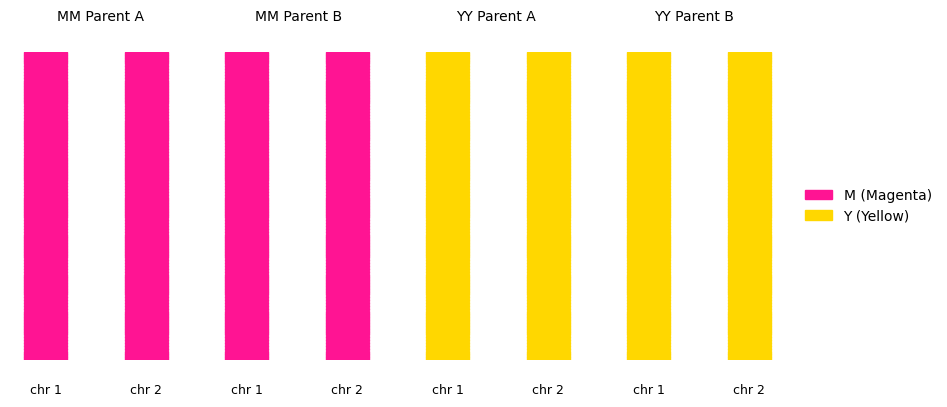

In [314]:
# Visualise parents
# Colour map for alleles
color_map = {'M': 'deeppink', 'Y': 'gold'}

# Updated order: MM A, MM B, YY A, YY B
titles = ["MM Parent A", "MM Parent B", "YY Parent A", "YY Parent B"]

# Chromosome pairs per individual (same order as titles)
parent_chr_pairs = [
    (mm_parent_a[0], mm_parent_a[1]),
    (mm_parent_b[0], mm_parent_b[1]),
    (yy_parent_a[0], yy_parent_a[1]),
    (yy_parent_b[0], yy_parent_b[1])
]

# Dynamically scale figure width: 0.1 inch per locus per chromosome
fig_width = max(8, chromosome_length * 0.1)  # e.g., 100 loci → 10" width per chromosome
fig, axs = plt.subplots(1, 8, figsize=(fig_width, 4), sharey=True)

# Drawing settings
block_width = 0.6
block_height = 1
block_spacing = 1.2

# Loop through each individual and each chromosome
for i, (chr1, chr2) in enumerate(parent_chr_pairs):
    for j, chr in enumerate([chr1, chr2]):  # chr1 (0), chr2 (1)
        ax_index = i * 2 + j  # Convert to flat index (0 to 7)
        ax = axs[ax_index]
        for k, allele in enumerate(chr):
            y_pos = k * block_spacing
            ax.add_patch(
                mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele])
            )
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(chr) * block_spacing)
        ax.axis('off')

# Add individual titles centered above each pair of chromosomes
for i, title in enumerate(titles):
    mid_ax = axs[i * 2 + 0]
    mid_x = mid_ax.get_position().x0 + (axs[i * 2 + 1].get_position().x1 - mid_ax.get_position().x0) / 2
    fig.text(mid_x, 0.95, title, ha='center', va='bottom', fontsize=10)

# Add chromosome labels below each block
for i in range(4):  # For each parent
    axs[i * 2 + 0].text(0.5, -0.1, "chr 1", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 0].transAxes)
    axs[i * 2 + 1].text(0.5, -0.1, "chr 2", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 1].transAxes)

# Add legend
legend_patches = [
    mpatches.Patch(color='deeppink', label='M (Magenta)'),
    mpatches.Patch(color='gold', label='Y (Yellow)')
]
axs[-1].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.subplots_adjust(wspace=0.4)  # add spacing between the 8 subplots
plt.show()

### F1 Visual

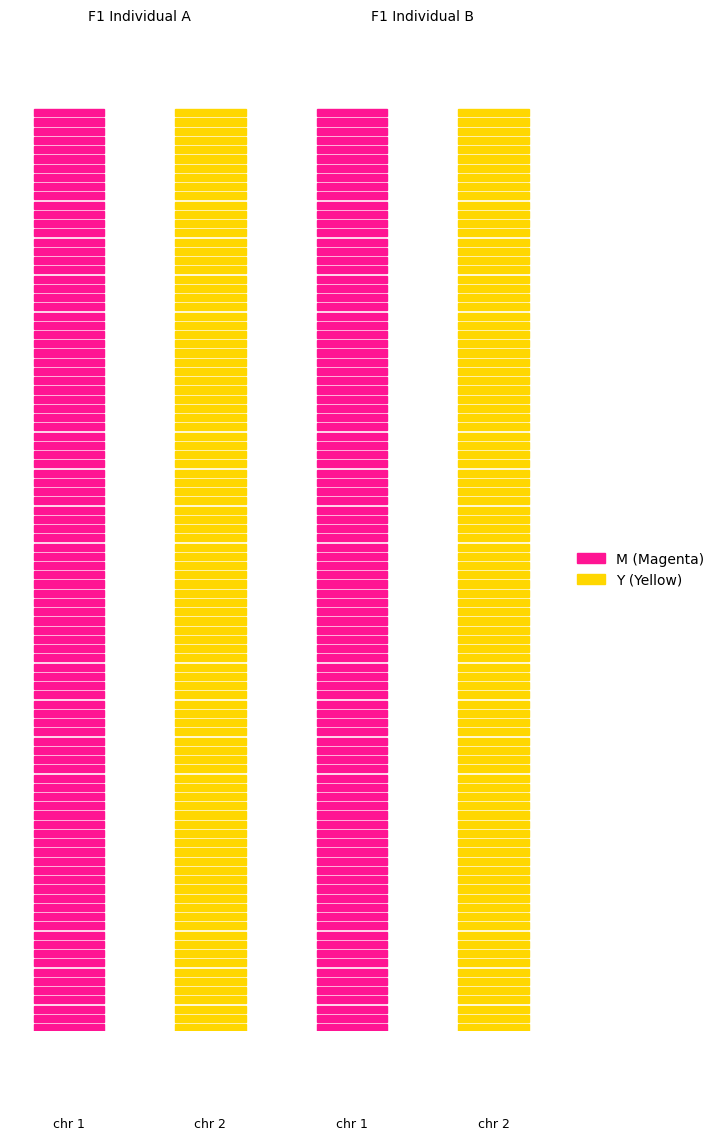

In [243]:
# Visualise F1 individuals
fig_height = max(6, chromosome_length * 0.12)  # 0.12" per locus, minimum 6"
fig, axs = plt.subplots(1, 4, figsize=(7, fig_height), sharey=True)

# Titles for each F1 individual
titles = ["F1 Individual A", "F1 Individual B"]

# Chromosome data grouped (chr1, chr2 per individual)
f1_chr_pairs = [
    (f1_a[0], f1_a[1]),
    (f1_b[0], f1_b[1])
]

# Drawing settings
block_width = 0.6
block_height = 1
block_spacing = 1.3

# Plot each chromosome in horizontal layout
for i, (chr1, chr2) in enumerate(f1_chr_pairs):
    for j, chr in enumerate([chr1, chr2]):  # chr1 then chr2
        ax_index = i * 2 + j
        ax = axs[ax_index]
        for k, allele in enumerate(chr):
            y_pos = k * block_spacing
            ax.add_patch(
                mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele])
            )
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(chr) * block_spacing)
        ax.axis('off')

# Add individual titles above their chromosome pair
for i, title in enumerate(titles):
    mid_ax = axs[i * 2]
    mid_x = mid_ax.get_position().x0 + (axs[i * 2 + 1].get_position().x1 - mid_ax.get_position().x0) / 2
    fig.text(mid_x, 0.95, title, ha='center', va='bottom', fontsize=10)

# Add chromosome labels just below blocks
for i in range(2):  # For each F1 individual
    axs[i * 2 + 0].text(0.5, -0.1, "chr 1", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 0].transAxes)
    axs[i * 2 + 1].text(0.5, -0.1, "chr 2", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 1].transAxes)

# Add legend on the right
axs[-1].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.show()

### Hybrid Index Calculation Parents and F1

In [315]:
# 'M' = magenta, 'Y' = yellow
# MM = 2, MY/YM = 1, YY = 0

# Function to convert two chrs into numeric genotypes
def get_numeric_genotype(chr1, chr2):
    numeric = []
    for a, b in zip(chr1, chr2):
        pair = sorted([a, b])  # account for 'MY' and 'YM' 
        if pair == ['M', 'M']:
            numeric.append(2)
        elif pair == ['Y', 'Y']:
            numeric.append(0)
        else:
            numeric.append(1)
    return numeric

# Function to calculate HI and HET from numeric genotype
def calculate_hi_het(genotype_numeric):
    num_loci = len(genotype_numeric)
    total_alleles = 2 * num_loci
    num_mm = genotype_numeric.count(2)
    num_yy = genotype_numeric.count(0)
    num_het = genotype_numeric.count(1)
    num_m_alleles = (2 * num_mm) + (1 * num_het)
    hi = num_m_alleles / total_alleles
    het = num_het / num_loci
    return hi, het

# Get numerci genotype for each individual 

# MM and YY parents of F1_A
genotype_mm_a = get_numeric_genotype(mm_parent_a[0], mm_parent_a[1])
genotype_yy_a = get_numeric_genotype(yy_parent_a[0], yy_parent_a[1])

# MM and YY parents of F1_B
genotype_mm_b = get_numeric_genotype(mm_parent_b[0], mm_parent_b[1])
genotype_yy_b = get_numeric_genotype(yy_parent_b[0], yy_parent_b[1])

# F1 Individuals
genotype_f1_a = get_numeric_genotype(f1_a[0], f1_a[1])
genotype_f1_b = get_numeric_genotype(f1_b[0], f1_b[1])

# Calculate HI and HET (Hybrid Index and Heterozygosity)

hi_mm_a, het_mm_a = calculate_hi_het(genotype_mm_a)
hi_yy_a, het_yy_a = calculate_hi_het(genotype_yy_a)

hi_mm_b, het_mm_b = calculate_hi_het(genotype_mm_b)
hi_yy_b, het_yy_b = calculate_hi_het(genotype_yy_b)

hi_f1_a, het_f1_a = calculate_hi_het(genotype_f1_a)
hi_f1_b, het_f1_b = calculate_hi_het(genotype_f1_b)

In [316]:
# Output results 

print(f"F1_A's MM Parent -> HI: {hi_mm_a:.2f}, HET: {het_mm_a:.2f}")
print(f"F1_A's YY Parent -> HI: {hi_yy_a:.2f}, HET: {het_yy_a:.2f}")
print(f"F1_A Individual  -> HI: {hi_f1_a:.2f}, HET: {het_f1_a:.2f}")
print()
print(f"F1_B's MM Parent -> HI: {hi_mm_b:.2f}, HET: {het_mm_b:.2f}")
print(f"F1_B's YY Parent -> HI: {hi_yy_b:.2f}, HET: {het_yy_b:.2f}")
print(f"F1_B Individual  -> HI: {hi_f1_b:.2f}, HET: {het_f1_b:.2f}")


F1_A's MM Parent -> HI: 1.00, HET: 0.00
F1_A's YY Parent -> HI: 0.00, HET: 0.00
F1_A Individual  -> HI: 0.50, HET: 1.00

F1_B's MM Parent -> HI: 1.00, HET: 0.00
F1_B's YY Parent -> HI: 0.00, HET: 0.00
F1_B Individual  -> HI: 0.50, HET: 1.00


### F2 generation

In [317]:
# Function to get recombination points across F2 pop
def get_recomb_points(chrom_length, num_events, recomb_probs):
    
    # Only positions 1 to (chrom_length - 1) are valid recombination sites
    possible_positions = list(range(1, chrom_length))  # skip 0 (can't recombine before first locus)
    
    # Normalise probabilities over valid positions
    position_probs = np.array(recomb_probs[1:])  # slice from index 1 onward
    position_probs = position_probs / position_probs.sum()  # ensure it sums to 1
    
    # Sample recombination points without replacement, weighted by recomb_probs
    return sorted(np.random.choice(possible_positions, size=num_events, replace=False, p=position_probs))

In [318]:
#F2 Simulation

# Function to generate one F2 offspring from two F1 parents
def generate_f2_offspring(parent_a, parent_b, chromosome_length):
    chr_1, chr_2 = [], []

    num_recomb_1 = np.random.choice([0, 1, 2], p=recomb_event_probs)
    num_recomb_2 = np.random.choice([0, 1, 2], p=recomb_event_probs)
    
    recomb_points_1 = get_recomb_points(chromosome_length, num_recomb_1, recomb_probs)
    recomb_points_2 = get_recomb_points(chromosome_length, num_recomb_2, recomb_probs)

    chr_1_source = np.random.choice([0, 1])
    chr_2_source = np.random.choice([0, 1])

    switch_index_1 = 0
    switch_index_2 = 0

    for i in range(chromosome_length):
        if switch_index_1 < len(recomb_points_1) and i == recomb_points_1[switch_index_1]:
            chr_1_source = 1 - chr_1_source
            switch_index_1 += 1
        if switch_index_2 < len(recomb_points_2) and i == recomb_points_2[switch_index_2]:
            chr_2_source = 1 - chr_2_source
            switch_index_2 += 1

        chr_1.append(parent_a[chr_1_source][i] if chr_1_source == 0 else parent_b[chr_1_source][i])
        chr_2.append(parent_a[chr_2_source][i] if chr_2_source == 0 else parent_b[chr_2_source][i])

    return (chr_1, chr_2)

# Create F2 population without repetition of F1 parents
f2_population = []

# Shuffle indices and pair them up
f1_indices = np.random.permutation(len(f1_offspring))
pairs = list(zip(f1_indices[::2], f1_indices[1::2]))

for idx_a, idx_b in pairs:
    parent_a = f1_offspring[idx_a]
    parent_b = f1_offspring[idx_b]
    f2_individual = generate_f2_offspring(parent_a, parent_b, chromosome_length)
    f2_population.append(f2_individual)

In [319]:
# Return F2 population size and chromosome length as a check
len(f2_population), len(f2_population[0][0])  

(50, 100)

In [320]:
# Checkpoint

print(f"Number of F2 individuals: {len(f2_population)}")

first = f2_population[0]
print("Length of individual (should be 2 chromosomes):", len(first))
print("First few alleles of chr_1:", first[0][:5])
print("First few alleles of chr_2:", first[1][:5])

Number of F2 individuals: 50
Length of individual (should be 2 chromosomes): 2
First few alleles of chr_1: ['M', 'M', 'M', 'M', 'M']
First few alleles of chr_2: ['Y', 'Y', 'Y', 'Y', 'Y']


In [321]:
# Checkpoint: 

# Check lengths of chromosomes across the population
chrom_lengths = [ (len(ind[0]), len(ind[1])) for ind in f2_population ]
print("Chromosome lengths (chr1, chr2) for first few individuals:", chrom_lengths[:5])

Chromosome lengths (chr1, chr2) for first few individuals: [(100, 100), (100, 100), (100, 100), (100, 100), (100, 100)]


In [322]:
# Checkpoint: 

# Check data types
print(isinstance(f2_population, list))                 # Expect: True
print(isinstance(f2_population[0], tuple))             # Expect: True
print(isinstance(f2_population[0][0], list))           # Expect: True
print(isinstance(f2_population[0][0][0], str))         # Expect: True (allele should be 'M' or 'Y')

True
True
True
True


In [323]:
# Compute genotype numeric representation
# Lists to store data for the entire F2 population
f2_genotype_numeric_all = []    # List of lists (each individual's numeric genotypes)
f2_genotype_labels_all = []     # List of lists (each individual's genotype labels)

# Loop over each individual in the F2 population
for chr_1, chr_2 in f2_population:
    
    f2_genotype_numeric = []   # Genotype numeric for this individual
    f2_genotype_labels = []    # Genotype label for this individual

    # Loop through alleles at each position from both chromosomes
    for a, b in zip(chr_1, chr_2):
        pair = sorted([a, b])  # Sort to standardise MM, MY, etc.
        
        if pair == ['M', 'M']:
            f2_genotype_numeric.append(2)
            f2_genotype_labels.append('MM')
        elif pair == ['Y', 'Y']:
            f2_genotype_numeric.append(0)
            f2_genotype_labels.append('YY')
        else:
            f2_genotype_numeric.append(1)
            f2_genotype_labels.append(a + b)  # Keep orientation ('MY' or 'YM')

    # Append this individual's data to the population-level lists
    f2_genotype_numeric_all.append(f2_genotype_numeric)
    f2_genotype_labels_all.append(f2_genotype_labels)

In [324]:
# Checkpoint: convert to pd dataframe for summary 

import pandas as pd

# Convert numeric genotypes into a DataFrame
f2_genotype_df = pd.DataFrame(f2_genotype_numeric_all)

# Optional: assign meaningful column names (e.g., loci positions)
f2_genotype_df.columns = [f"Locus_{i+1}" for i in range(f2_genotype_df.shape[1])]

# Add individual IDs
f2_genotype_df['Individual_ID'] = [f"F2_{i+1}" for i in range(len(f2_genotype_df))]

# Reorder to make ID the first column
f2_genotype_df = f2_genotype_df[['Individual_ID'] + [col for col in f2_genotype_df.columns if col != 'Individual_ID']]

# Preview the first few rows
print(f2_genotype_df.head())


  Individual_ID  Locus_1  Locus_2  Locus_3  Locus_4  Locus_5  Locus_6  \
0          F2_1        1        1        1        1        1        1   
1          F2_2        0        0        0        0        0        0   
2          F2_3        0        0        0        0        0        0   
3          F2_4        1        1        1        1        2        2   
4          F2_5        1        1        1        1        1        1   

   Locus_7  Locus_8  Locus_9  ...  Locus_91  Locus_92  Locus_93  Locus_94  \
0        1        1        1  ...         1         1         1         1   
1        0        0        0  ...         2         2         2         2   
2        0        0        0  ...         2         2         2         2   
3        2        2        2  ...         1         1         1         1   
4        1        1        1  ...         1         1         1         1   

   Locus_95  Locus_96  Locus_97  Locus_98  Locus_99  Locus_100  
0         1         1         1  

### F2 Visual

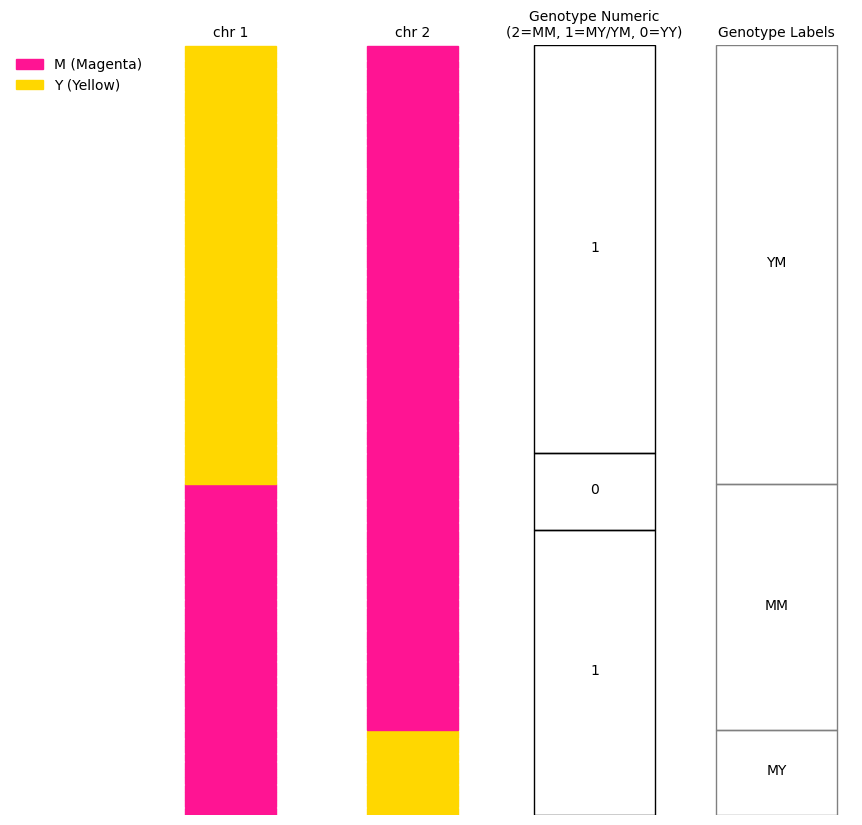

In [325]:
# Visualise F2 chromosome vertically
# Define colour for M and Y
color_map = {'M': 'deeppink', 'Y': 'gold'}

# Set block display properties
block_width = 0.6
block_height = 1
block_spacing = 1.08

# Create figure with 1 row and 4 vertical strip subplots
fig, axs = plt.subplots(1, 4, figsize=(9, 10), sharey=True)

# Titles for each vertical strip
titles = [
    "chr 1",
    "chr 2",
    "Genotype Numeric\n(2=MM, 1=MY/YM, 0=YY)",
    "Genotype Labels"
]

# Plot allele chr 1
for i, allele in enumerate(chr_1):
    y_pos = i * block_spacing
    axs[0].add_patch(mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele]))

# Plot allele chr 2
for i, allele in enumerate(chr_2):
    y_pos = i * block_spacing
    axs[1].add_patch(mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele]))

# Plot genotype numeric values
# Function to group consecutive identical items
def group_runs(data):
    runs = []
    start = 0
    for i in range(1, len(data)):
        if data[i] != data[start]:
            runs.append((start, i - 1, data[start]))
            start = i
    runs.append((start, len(data) - 1, data[start]))
    return runs

# Group numeric values
numeric_runs = group_runs(f2_chromosome)
for start, end, val in numeric_runs:
    y_start = start * block_spacing
    height = (end - start + 1) * block_spacing
    axs[2].add_patch(mpatches.Rectangle((0.1, y_start), block_width + 0.2, height, edgecolor='black', facecolor='white', fill=False))
    axs[2].text(0.5, y_start + height / 2 - 0.3, str(val), fontsize=10, ha='center')

# Plot genotype labels
# Function to group consecutive identical items
def group_runs(data):
    runs = []
    start = 0
    for i in range(1, len(data)):
        if data[i] != data[start]:
            runs.append((start, i - 1, data[start]))
            start = i
    runs.append((start, len(data) - 1, data[start]))
    return runs

# Clean label input (remove extra spaces, standardize)
clean_labels = [label.strip().upper() for label in f2_genotype_labels]

# Group identical label stretches
label_runs = group_runs(clean_labels)

# Plot merged genotype label blocks
for start, end, label in label_runs:
    y_start = start * block_spacing
    height = (end - start + 1) * block_spacing
    axs[3].add_patch(mpatches.Rectangle((0.1, y_start), block_width + 0.2, height,
                                        edgecolor='grey', facecolor='white', fill=False))
    axs[3].text(0.5, y_start + height / 2 - 0.3, label, fontsize=10, ha='center')

# Formatting
max_y = len(chr_1) * block_spacing
for ax, title in zip(axs, titles):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, max_y)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# Add legend to first column
legend_patches = [
    mpatches.Patch(color='deeppink', label='M (Magenta)'),
    mpatches.Patch(color='gold', label='Y (Yellow)')
]
axs[0].legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(-1, 1), frameon=False)

plt.show()

In [326]:
# Checkpoint - for verification purposes 

print("chr 1:", chr_1)
print("chr 2:", chr_2)
print("F2 Chromosome Genotype:", f2_chromosome)

chr 1: ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
chr 2: ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',

### Hybrid Index Calculation F2

In [327]:
# Create a list to store numeric genotype lists for each individual
f2_population_numeric = []

# Loop through each F2 individual (pair of chromosomes)
for chr_1, chr_2 in f2_population:
    f2_numeric = []
    for a, b in zip(chr_1, chr_2):
        pair = sorted([a, b])
        if pair == ['M', 'M']:
            f2_numeric.append(2)
        elif pair == ['Y', 'Y']:
            f2_numeric.append(0)
        else:
            f2_numeric.append(1)
    f2_population_numeric.append(f2_numeric)

In [328]:
#Hi and Het Calc for F2 Pop 
f2_genotype_df = pd.DataFrame(f2_population_numeric)

# Optionally add an Individual_ID column if you want
f2_genotype_df.insert(0, 'Individual_ID', [f'F2_{i+1}' for i in range(len(f2_genotype_df))])

# Get number of loci (i.e., number of columns excluding ID)
num_loci = f2_genotype_df.shape[1] - 1

# Calculate Hybrid Index for each individual
# Sum across loci and divide by total possible M alleles (2 per locus)
f2_genotype_df['Hybrid_Index'] = (
    f2_genotype_df.drop('Individual_ID', axis=1).sum(axis=1) / (2 * num_loci)
)

# Calculate Heterozygosity for each individual (proportion of loci that are heterozygous, value = 1)
f2_genotype_df['Heterozygosity'] = (
    (f2_genotype_df.drop('Individual_ID', axis=1) == 1).sum(axis=1) / num_loci
)

# Check the first few rows
print(f2_genotype_df.head())

  Individual_ID  0  1  2  3  4  5  6  7  8  ...  92  93  94  95  96  97  98  \
0          F2_1  1  1  1  1  1  1  1  1  1  ...   1   1   1   1   1   1   1   
1          F2_2  0  0  0  0  0  0  0  0  0  ...   2   2   2   2   2   2   2   
2          F2_3  0  0  0  0  0  0  0  0  0  ...   2   2   2   2   2   2   2   
3          F2_4  1  1  1  1  2  2  2  2  2  ...   1   1   1   1   1   1   1   
4          F2_5  1  1  1  1  1  1  1  1  1  ...   1   1   1   1   1   1   1   

   99  Hybrid_Index  Heterozygosity  
0   1         0.545            0.91  
1   2         0.505            0.29  
2   2         0.810            0.06  
3   1         0.575            0.85  
4   1         0.410            0.82  

[5 rows x 103 columns]


### F2 Pop for triangle plot

In [329]:
# Get Hybrid Index and Heterozygosity as coordinate pairs for F2 population
f2_coords = list(zip(f2_genotype_df['Hybrid_Index'], f2_genotype_df['Heterozygosity']))

In [330]:
# Plot F2 population points (gray and semi-transparent for density)
ax.scatter(
    f2_genotype_df['Hybrid_Index'],
    f2_genotype_df['Heterozygosity'],
    color='black',
    alpha=0.3,
    s=20,
    label='F2 Pop'
)

### Triangle Plot

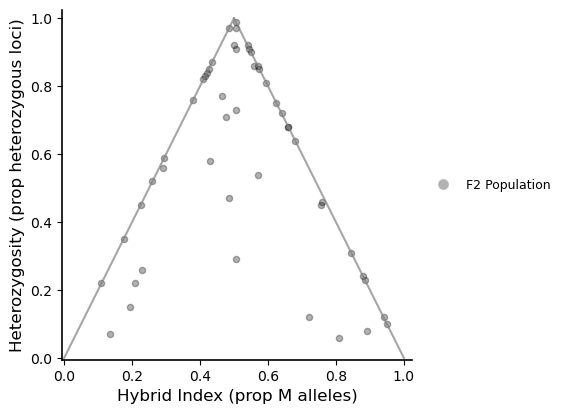

In [331]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Remove only top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Label axes
ax.set_xlabel("Hybrid Index (prop M alleles)", fontsize=12)
ax.set_ylabel("Heterozygosity (prop heterozygous loci)", fontsize=12)

# Plot all F2 individuals as semi-transparent black dots
ax.scatter(
    f2_genotype_df['Hybrid_Index'],
    f2_genotype_df['Heterozygosity'],
    color='black',
    alpha=0.3,
    s=20,
    label='F2 Population'
)

# Set axis limits and remove grid
ax.set_xlim(-0.005, 1.025)
ax.set_ylim(-0.005, 1.025)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

# Add triangle edges (without base)
triangle_edges = [
    [(0.0, 0.0), (0.5, 1.0)],  # YY to F1
    [(0.5, 1.0), (1.0, 0.0)]   # F1 to MM
]
for (x0, y0), (x1, y1) in triangle_edges:
    ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

# Legend with F2 population only
custom_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', alpha=0.3, markersize=8, label='F2 Population')
]

ax.legend(
    handles=custom_legend,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=9
)

# Layout adjustment
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.2)
plt.show()